In [1]:
!pip install deepctr[gpu]

     |████████████████████████████████| 112kB 7.9MB/s 
     |████████████████████████████████| 320.4MB 48kB/s 


In [30]:
# 모듈 불러오기
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# from deepctr.models import DeepFM
from deepctr.models.xdeepfm import xDeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

In [18]:
# 데이터 로드
# data = pd.read_csv("./data/범주데이터모음.csv", usecols=lambda x: 'Unnamed' not in x)
data = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/범주데이터모음2.csv", 
                   usecols=lambda x: 'Unnamed' not in x)
data2 = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/deepfm데이터.csv",
                    usecols=lambda x: 'Unnamed' not in x)

# 컬럼 확인

* Issue1: 데이터 오류
    - `deepfm데이터.csv` 사용하면 판다스 에러가 난다.
    - 일단 기존에 사용한 `범주데이터모음2.csv`를 사용해서 판매 단가만 붙인다.
    - 취급액이 0인 데이터도 제외한다.

* Issue2: 데이터 더 넣어도 될 듯? 
    - dense features로서 기온, 습도 등 시계열 데이터, 
    - sparse feature로서 미세먼지 등?

In [19]:
# 컬럼 확인
len(data.columns), data.columns, len(data2.columns), data2.columns

(47,
 Index(['취급액', '요일', '시간', '월', '고유상품명', '계절', '노출횟수', '주의보bin3', '주의보bin4',
        '주의보유무', '경보유무', '일별강수량sum_cat', '일별적설sum_cat', '일별기온평균1', '일별기온최대1',
        '일별기온최소1', '일별기온평균2', '일별기온최대2', '일별기온최소2', '일교차1', '일별습도평균1',
        '일별습도평균2', '일별습도최대2', '일조량1', '요일 맵핑', '시간 맵핑', '월 맵핑', '고유상품명 맵핑',
        '계절 맵핑', '노출횟수 맵핑', '주의보bin3 맵핑', '주의보bin4 맵핑', '주의보유무 맵핑', '경보유무 맵핑',
        '일별강수량sum_cat 맵핑', '일별적설sum_cat 맵핑', '일별기온평균1 맵핑', '일별기온최대1 맵핑',
        '일별기온최소1 맵핑', '일별기온평균2 맵핑', '일별기온최대2 맵핑', '일별기온최소2 맵핑', '일교차1 맵핑',
        '일별습도평균1 맵핑', '일별습도평균2 맵핑', '일별습도최대2 맵핑', '일조량1 맵핑'],
       dtype='object'),
 27,
 Index(['취급액', '요일 맵핑', '시간 맵핑', '월 맵핑', '성별 맵핑', '고유상품명 맵핑', '브랜드 맵핑', '계절 맵핑',
        '노출횟수 맵핑', '주의보bin3 맵핑', '주의보bin4 맵핑', '주의보유무 맵핑', '경보유무 맵핑',
        '일별강수량sum_cat 맵핑', '일별적설sum_cat 맵핑', '일별기온평균1 맵핑', '일별기온최대1 맵핑',
        '일별기온최소1 맵핑', '일별기온평균2 맵핑', '일별기온최대2 맵핑', '일별기온최소2 맵핑', '일교차1 맵핑',
        '일별습도평균1 맵핑', '일별습도평균2 맵핑', '일별습도최대2 맵핑', '일조량1 맵핑', '판매단가'],
      

In [22]:
# 데이터 추출
df1 = data[[x for x in data.columns if '맵핑' in x or x == '취급액']]
df2 = data2[['판매단가']]
df = pd.concat([df1, df2], axis=1)
df.tail()

,취급액,요일 맵핑,시간 맵핑,월 맵핑,고유상품명 맵핑,계절 맵핑,노출횟수 맵핑,주의보bin3 맵핑,주의보bin4 맵핑,주의보유무 맵핑,경보유무 맵핑,일별강수량sum_cat 맵핑,일별적설sum_cat 맵핑,일별기온평균1 맵핑,일별기온최대1 맵핑,일별기온최소1 맵핑,일별기온평균2 맵핑,일별기온최대2 맵핑,일별기온최소2 맵핑,일교차1 맵핑,일별습도평균1 맵핑,일별습도평균2 맵핑,일별습도최대2 맵핑,일조량1 맵핑,판매단가
13274,76448000,0,15,11,35,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1499000
13275,58429000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,148000
13276,128803000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,168000
13277,16713000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,158000
13278,64651000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,178000


In [23]:
# 취급액 0인 데이터 제외
df = df.loc[df['취급액'] != 0].reset_index(drop=True)
df

,취급액,요일 맵핑,시간 맵핑,월 맵핑,고유상품명 맵핑,계절 맵핑,노출횟수 맵핑,주의보bin3 맵핑,주의보bin4 맵핑,주의보유무 맵핑,경보유무 맵핑,일별강수량sum_cat 맵핑,일별적설sum_cat 맵핑,일별기온평균1 맵핑,일별기온최대1 맵핑,일별기온최소1 맵핑,일별기온평균2 맵핑,일별기온최대2 맵핑,일별기온최소2 맵핑,일교차1 맵핑,일별습도평균1 맵핑,일별습도평균2 맵핑,일별습도최대2 맵핑,일조량1 맵핑,판매단가
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900
1,20663000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900
2,47878000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59000
3,99736000,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59900
4,90973000,0,3,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13004,76448000,0,15,11,35,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1499000
13005,58429000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,148000
13006,128803000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,168000
13007,16713000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,158000


# 모델링

 price scaling 방법
- `np.log1p`
- `minmax scaling`
- `np.log1p` + `minmax scaling`


In [26]:
# 컬럼 이름 영어로 변환
df.columns = ['AMT', 'day', 'hour', 'month', 'product_name', 'season', 'exposure_cnt',
              'warning_bin3', 'warning_bin4', 'is_warning', 'is_alert', 'daily_precipitation_sum', 
              'daily_snow_sum', 'daily_temp_mean_1', 'daily_temp_max_1', 'daily_temp_min_1',
              'daily_temp_mean_2', 'daily_temp_max_2', 'daily_temp_min_2', 'daily_temp_diff_1', 'daily_humidity_mean_1', 
              'daily_humidity_mean_2', 'daily_humidity_max_2', 'daily_sunshine',
              'product_price']
df.head()

,AMT,day,hour,month,product_name,season,exposure_cnt,warning_bin3,warning_bin4,is_warning,is_alert,daily_precipitation_sum,daily_snow_sum,daily_temp_mean_1,daily_temp_max_1,daily_temp_min_1,daily_temp_mean_2,daily_temp_max_2,daily_temp_min_2,daily_temp_diff_1,daily_humidity_mean_1,daily_humidity_mean_2,daily_humidity_max_2,daily_sunshine,product_price
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900
1,20663000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900
2,47878000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59000
3,99736000,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59900
4,90973000,0,3,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79000


In [29]:
# price scaling
df['product_price'] = np.log1p(df['product_price'])
df.tail()

,AMT,day,hour,month,product_name,season,exposure_cnt,warning_bin3,warning_bin4,is_warning,is_alert,daily_precipitation_sum,daily_snow_sum,daily_temp_mean_1,daily_temp_max_1,daily_temp_min_1,daily_temp_mean_2,daily_temp_max_2,daily_temp_min_2,daily_temp_diff_1,daily_humidity_mean_1,daily_humidity_mean_2,daily_humidity_max_2,daily_sunshine,product_price
13004,76448000,0,15,11,35,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,14.220309
13005,58429000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,11.904974
13006,128803000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,12.031725
13007,16713000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,11.970357
13008,64651000,0,17,11,241,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,12.089544


In [33]:
# feature, target 정의
sparse_features = ['day', 'hour', 'month', 'product_name', 'season', 'exposure_cnt',
                   'warning_bin3', 'warning_bin4', 'is_warning', 'is_alert', 'daily_precipitation_sum', 
                   'daily_snow_sum', 'daily_temp_mean_1', 'daily_temp_max_1', 'daily_temp_min_1',
                   'daily_temp_mean_2', 'daily_temp_max_2', 'daily_temp_min_2', 'daily_temp_diff_1', 'daily_humidity_mean_1',
                   'daily_humidity_mean_2', 'daily_humidity_max_2', 'daily_sunshine']
dense_features = ['product_price']
target = ['AMT']

# feature column 정의
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(), embedding_dim=6) for feat in sparse_features]\
                        + [DenseFeat(feat, 1, ) for feat in dense_features]                                                         
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(fixlen_feature_columns)
print(feature_names)

[SparseFeat(name='day', vocabulary_size=7, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f4e3284e0f0>, embedding_name='day', group_name='default_group', trainable=True), SparseFeat(name='hour', vocabulary_size=21, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f4e3284e240>, embedding_name='hour', group_name='default_group', trainable=True), SparseFeat(name='month', vocabulary_size=12, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7f4e31efde80>, embedding_name='month', group_name='default_group', trainable=True), SparseFeat(name='product_name', vocabulary_size=956, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initial

In [34]:
# 트레인, 테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target],
                                                    test_size=0.2, random_state=2020)

# 입력 데이터
X_train = {name:X_train[name].values for name in feature_names}
X_test = {name:X_test[name].values for name in feature_names}

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


33/33 [==============================] - 2s 48ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/500
33/33 [==============================] - 1s 20ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9998 - val_loss: 99.9999
Epoch 5/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9998 - val_loss: 99.9998
Epoch 6/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9996 - val_loss: 99.9998
Epoch 7/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9994 - val_loss: 99.9996
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9991 - val_loss: 99.9995
Epoch 9/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9988 - val_loss: 99.9994
Epoch 10/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9985 - val_l

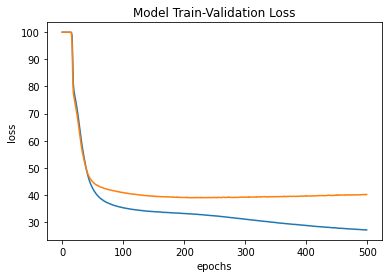

In [35]:
K.clear_session()

# 모델 학습
model = xDeepFM(linear_feature_columns, dnn_feature_columns, 
                dnn_use_bn=True, task='regression')
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mape')
# model.compile(optimizers.RMSprop(learning_rate=0.001), loss='mape')

# 모델 훈련
hist = model.fit(X_train, y_train,
                 batch_size=256,
                 epochs=500,
                 verbose=1,
                 validation_split=0.2)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Train-Validation Loss')
plt.show()

# 예측

 Train, Validation Loss는 괜찮은데 test data에 대해서는 별로 좋지 않은 듯하다. 튜닝 필요함.

In [37]:
# 평가지표 산식
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
# 예측
y_pred = model.predict(X_test)
y_pred

array([[5.9476310e+06],
       [4.0036056e+07],
       [1.5206029e+08],
       ...,
       [8.2791105e+06],
       [3.8618904e+07],
       [8.6990704e+07]], dtype=float32)

In [45]:
# MAPE 계산
mean_absolute_percentage_error(y_pred.reshape(-1, ), y_test['AMT'])

149.51093239423034